# Data Science Research Project 2
## Pridicting Customer Churn in Telecom Industry 

<b>1- General Information about the dataset</b>

<b>2- Project Opjectives:
* to utilize light gradient boosted machine (LGBM) in predicting customer churn and understand features importance.
* modeling umbalanced classes.
* to tune LGBM parameters using GridSearchCV to find the best performing parametes that suits the dataset.
* benchmarking the results to other research papers that used the same dataset for churn prediction.</b>

### Required Libraries

In [1]:
# Dataframe and plotting libraries
import numpy as np # For linear algebra
import pandas as pd # For data frame manipulation
import seaborn as sns # For visualization I
import matplotlib.pyplot as plt # For visualization II


# Machine Learing libraries
from sklearn.linear_model import LogisticRegression # Model 1
from sklearn.ensemble import RandomForestClassifier # Model 2
from sklearn.svm import SVC                         # Model 3
import xgboost as xgb                               # Model 4
from lightgbm import LGBMClassifier                 # Model 5

from sklearn.model_selection import StratifiedShuffleSplit # To stratify split
from sklearn.model_selection import StratifiedKFold # To stratify kfolds
from sklearn.model_selection import GridSearchCV # To find best parameters 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support # To evaluate models
from sklearn.metrics import classification_report # To evaluate models
from sklearn.metrics import confusion_matrix # To plot models outcome


from sklearn.preprocessing import MinMaxScaler # To scale data
from imblearn.under_sampling import RandomUnderSampler # To undersample data
from imblearn.over_sampling import RandomOverSampler, SMOTE # To oversample and resample data



# Utility library
import pickle # Save the ML object model.
import os # To access directory
import warnings  # To mute warnings
warnings.filterwarnings("ignore") # Mute warning

%matplotlib inline 

C:\Users\HP\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\HP\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\HP\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\HP\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from panda

## Useful function for evaluation

In [2]:
# Defining auxiliary function 1
rs = 123 # Setting random state to '123' in all models and sampling.

# Defining auxiliary function 2
# evaluation metrics stored in a dictionary
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    W_precision, W_recall, W_fbeta, _ = precision_recall_fscore_support(yt, yp, average = 'weighted')
    
    results_pos['precision'] = precision
    results_pos['Weighted precision'] = W_precision
    results_pos['recall'] = recall
    results_pos['Weighted recall'] = W_recall
    results_pos['f1score'] = f_beta
    results_pos['Weighted f1score'] = W_fbeta
    return results_pos

# Extract and sort feature coefficients
def get_feature_coefs(regression_model, label_index, columns):
    coef_dict = {}
    for coef, feat in zip(regression_model.coef_[label_index, :], columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')
    return color_vals

# Visualize coefficients
def visualize_coefs(coef_dict):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')
    plt.show()
    

## Importing the dataset

In [53]:
df = pd.read_csv('Telecom_customer_churn.csv')# Reading the dataset
df = df.rename(columns = {"change_mou": "tenure", "mou_Mean": "contract"})

## Preprossing and General Understanding of the Data

In [54]:
print('The dataset first three rows are')
display(df.head(3))
print('')
print('The dataset last three rows are')
display(df.tail(3))

The dataset first three rows are


,rev_Mean,contract,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,tenure,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,0.0,N,U,Y,U,U,U,Y,1504.0,1000003



The dataset last three rows are


,rev_Mean,contract,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,tenure,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
99997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,U,Y,Y,U,U,U,N,433.0,1099998
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,S,U,U,U,U,U,N,75.0,1099999
99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,H,U,U,U,U,U,N,5.0,1100000


In [55]:
print('Checking for missing values per column:')
print(df.isna().sum())

Checking for missing values per column:
rev_Mean        357
contract        357
totmrc_Mean     357
da_Mean         357
ovrmou_Mean     357
               ... 
kid11_15       1732
kid16_17       1732
creditcd       1732
eqpdays           1
Customer_ID       0
Length: 100, dtype: int64


there're a lot of columns that has missing values more than 5 percent of the number of rows, which can significantly skew the data, this is why we will drop these columns

In [56]:
a = df.isna().sum() # counting the number of NA values in each columns
delete = df.columns[(a>5000)] # filtering out the columns that have more than 5000 NA values

In [57]:
df.drop(delete, axis = 1, inplace = True) # droping columns that contains NA values for more than 5% of the data size

In [58]:
df = df.dropna() # droping rows that contains NA values for the rest of the columns

as can be seen below, after droping the columns with significant number of NA values, removing NA values from the rest of the columns did not reduce the data size significantly.

In [59]:
df.shape 

(93893, 89)

In [60]:
# reseting the index as removing rows will affect the previous indexing
df.reset_index(inplace= True)
df.drop('index', inplace=True, axis=1)
df

,rev_Mean,contract,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,tenure,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.997500,219.250000,22.50,0.2475,0.000000,0.000000,0.000000,0.00,0.00,-157.250000,...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,16.990000,10.250000,16.99,0.0000,0.000000,0.000000,0.000000,0.00,0.00,-4.250000,...,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
2,38.000000,7.500000,38.00,0.0000,0.000000,0.000000,0.000000,0.00,0.00,-1.500000,...,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
3,55.230000,570.500000,71.98,0.0000,0.000000,0.000000,0.000000,0.00,0.00,38.500000,...,0.0,I,U,U,U,U,U,Y,434.0,1000005
4,82.275000,1312.250000,75.00,1.2375,0.000000,0.000000,0.000000,0.00,0.00,156.750000,...,0.0,U,U,U,U,U,U,Y,458.0,1000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93888,34.990000,6.333333,44.99,0.0000,0.000000,0.000000,0.000000,0.00,0.00,-6.333333,...,0.0,N,U,U,Y,U,U,Y,118.0,1099982
93889,85.150000,815.000000,87.99,0.0000,1.000000,0.390000,0.000000,0.39,0.39,0.000000,...,0.0,H,U,U,U,U,U,Y,230.0,1099985
93890,71.993333,724.000000,70.00,0.0000,4.333333,1.083333,1.083333,0.00,0.91,-40.000000,...,0.0,S,U,U,U,U,U,Y,882.0,1099986
93891,117.490000,384.000000,29.99,0.0000,250.000000,87.500000,87.500000,0.00,0.00,0.000000,...,0.0,S,U,U,U,U,U,Y,489.0,1099987


In [61]:
print('displaying the new shape of the data')
df.shape

displaying the new shape of the data


(93893, 89)

In [62]:
print(f'The data frame encompasses {df.shape[0]} instances and {df.shape[1]} features\n')
print('The features data types are as follows,')
print(df.dtypes.value_counts())

The data frame encompasses 93893 instances and 89 features

The features data types are as follows,
float64    65
object     14
int64      10
dtype: int64


As we're using decision trees algorithm as the base model of LGBM ensamble algorithm, we don't need to do feature scaling or encode the non numeric columns. However, because we're going to benchmark the results with other machine learning algoirthm that might require encoding and feature scaling such as logistic regression, we will do those steps right now so we wont have to do them later.

### Encoding the Data:
For columns that has only two values, they will be converted to 1s and 0s, but for columns that have 3 values and more they will be one hot encoded.

In [63]:
pd.set_option('display.max_rows', None) # increasing the number of rows that can be shown to see all column values

In [64]:
# dropping 'customerID' column first.
df.drop('Customer_ID', inplace=True, axis=1)
df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques

,Unique Values
Variable,
rev_Mean,35968
contract,9368
totmrc_Mean,7924
da_Mean,165
ovrmou_Mean,2506
ovrrev_Mean,11679
vceovr_Mean,7179
datovr_Mean,731
roam_Mean,5104


In [65]:
pd.reset_option('all') # reseting the number of rows that can be shown to default

In [66]:
object_variables = df.columns[df.dtypes == 'object']  # checking object columns

In [67]:
binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index) # taking only binary columns
binary_variables

['churn',
 'asl_flag',
 'refurb_new',
 'truck',
 'rv',
 'forgntvl',
 'kid0_2',
 'kid3_5',
 'kid6_10',
 'kid11_15',
 'kid16_17',
 'creditcd']

In [68]:
nonbinary_object_variables = list(set(object_variables) - set(binary_variables))
nonbinary_object_variables

['ethnic', 'crclscod', 'dualband', 'area', 'marital', 'new_cell']

In [69]:
[[i, list(df[i].unique())] for i in nonbinary_object_variables]

[['ethnic',
  ['N',
   'U',
   'I',
   'S',
   'F',
   'J',
   'Z',
   'M',
   'H',
   'G',
   'D',
   'O',
   'R',
   'B',
   'P',
   'X',
   'C']],
 ['crclscod',
  ['A',
   'C',
   'B',
   'BA',
   'D',
   'G',
   'CA',
   'AA',
   'U',
   'Z',
   'E',
   'EA',
   'J',
   'E4',
   'W',
   'DA',
   'Y',
   'CC',
   'GA',
   'D4',
   'D5',
   'H',
   'ZA',
   'JF',
   'K',
   'B2',
   'Z1',
   'O',
   'M',
   'U1',
   'Z4',
   'A2',
   'V',
   'I',
   'TP',
   'EM',
   'C2',
   'C5',
   'Z5',
   'D2',
   'GY',
   'ZY',
   'E2',
   'A3',
   'V1',
   'Z2',
   'CY',
   'EC',
   'P1',
   'IF',
   'ZF',
   'EF',
   'L']],
 ['dualband', ['Y', 'N', 'T']],
 ['area',
  ['NORTHWEST/ROCKY MOUNTAIN AREA',
   'GREAT LAKES AREA',
   'CHICAGO AREA',
   'NEW ENGLAND AREA',
   'DALLAS AREA',
   'CENTRAL/SOUTH TEXAS AREA',
   'TENNESSEE AREA',
   'MIDWEST AREA',
   'PHILADELPHIA AREA',
   'OHIO AREA',
   'HOUSTON AREA',
   'SOUTHWEST AREA',
   'NEW YORK CITY AREA',
   'ATLANTIC SOUTH AREA',
   'SOUTH FL

for nonbinary_object_variables, if they have values that are more than 3, they will be label encoded, the rest will be one hot encoded

In [70]:
labelencoder_columns = ['crclscod', 'ethnic', 'area']
onehotencoder_columns = ['dualband', 'new_cell', 'marital']

For the rest of float and integer columns will be scale using min maxing scaling to values between 0 and 1

In [71]:
# combining float and integer columns together
float_int_variables = df.columns[(df.dtypes == 'float64') | (df.dtypes == 'int64')]
float_int_variables

Index(['rev_Mean', 'contract', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean',
       'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'tenure',
       'change_rev', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean',
       'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean',
       'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean',
       'comp_dat_Mean', 'custcare_Mean', 'ccrndmou_Mean', 'cc_mou_Mean',
       'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean',
       'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean',
       'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean',
       'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean',
       'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean',
       'complete_Mean', 'callfwdv_Mean', 'callwait_Mean', 'churn', 'months',
       'uniqsubs', 'actvsubs', 'totcalls', 'totmou', 'totrev', 'adjrev',
       'adjmou', 'adjqty', 'avgrev', 'avgmou'

In [72]:
# excluding the columns that already exist in other set of columns, such as binary columns.
remaining = list(set(float_int_variables) - set(binary_variables))
remaining

['vceovr_Mean',
 'totrev',
 'blck_dat_Mean',
 'avgrev',
 'comp_vce_Mean',
 'avgmou',
 'unan_dat_Mean',
 'mou_opkd_Mean',
 'avg3qty',
 'adjqty',
 'avg6qty',
 'avg6rev',
 'comp_dat_Mean',
 'ccrndmou_Mean',
 'mou_opkv_Mean',
 'plcd_dat_Mean',
 'inonemin_Mean',
 'mou_cdat_Mean',
 'adjrev',
 'contract',
 'roam_Mean',
 'drop_dat_Mean',
 'phones',
 'tenure',
 'plcd_vce_Mean',
 'totmrc_Mean',
 'custcare_Mean',
 'attempt_Mean',
 'callwait_Mean',
 'threeway_Mean',
 'rev_Mean',
 'avg3mou',
 'peak_dat_Mean',
 'change_rev',
 'adjmou',
 'mouiwylisv_Mean',
 'mouowylisv_Mean',
 'avg3rev',
 'owylis_vce_Mean',
 'da_Mean',
 'models',
 'mou_cvce_Mean',
 'ovrrev_Mean',
 'recv_sms_Mean',
 'mou_peav_Mean',
 'unan_vce_Mean',
 'totmou',
 'blck_vce_Mean',
 'peak_vce_Mean',
 'hnd_price',
 'uniqsubs',
 'iwylis_vce_Mean',
 'opk_vce_Mean',
 'callfwdv_Mean',
 'cc_mou_Mean',
 'drop_vce_Mean',
 'mou_rvce_Mean',
 'opk_dat_Mean',
 'recv_vce_Mean',
 'totcalls',
 'complete_Mean',
 'mou_pead_Mean',
 'datovr_Mean',
 'eqpday

To sum up what we've done so far!, we've create the following groups of columns:

<ol>
  <li><b>binary_variables:</b> it contains binary columns and will be encoded using LabelBinarizer.</li>
  <li><b>labelencoder_columns:</b> it contains categorical columns that have more than 3 unique values and it will be encoded using label encoder.</li>
  <li><b>onehotencoder_columns:</b> it contains categorical columns that have  3 unique values or less and it will be encoded using one hot encoder.</li>
  <li><b>remaining:</b> it contains the remaining float and integer columns which will be scaled using min maxing scaling..</li>
</ol>

now let's scale all kinds of variables we have

In [73]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder

lb, le, one = LabelBinarizer(), LabelEncoder(), OneHotEncoder() # Initialize encoding objects.

print(binary_variables)
print(labelencoder_columns)
print(onehotencoder_columns)
print(remaining)

['churn', 'asl_flag', 'refurb_new', 'truck', 'rv', 'forgntvl', 'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd']
['crclscod', 'ethnic', 'area']
['dualband', 'new_cell', 'marital']
['vceovr_Mean', 'totrev', 'blck_dat_Mean', 'avgrev', 'comp_vce_Mean', 'avgmou', 'unan_dat_Mean', 'mou_opkd_Mean', 'avg3qty', 'adjqty', 'avg6qty', 'avg6rev', 'comp_dat_Mean', 'ccrndmou_Mean', 'mou_opkv_Mean', 'plcd_dat_Mean', 'inonemin_Mean', 'mou_cdat_Mean', 'adjrev', 'contract', 'roam_Mean', 'drop_dat_Mean', 'phones', 'tenure', 'plcd_vce_Mean', 'totmrc_Mean', 'custcare_Mean', 'attempt_Mean', 'callwait_Mean', 'threeway_Mean', 'rev_Mean', 'avg3mou', 'peak_dat_Mean', 'change_rev', 'adjmou', 'mouiwylisv_Mean', 'mouowylisv_Mean', 'avg3rev', 'owylis_vce_Mean', 'da_Mean', 'models', 'mou_cvce_Mean', 'ovrrev_Mean', 'recv_sms_Mean', 'mou_peav_Mean', 'unan_vce_Mean', 'totmou', 'blck_vce_Mean', 'peak_vce_Mean', 'hnd_price', 'uniqsubs', 'iwylis_vce_Mean', 'opk_vce_Mean', 'callfwdv_Mean', 'cc_mou_Mean', '

making sure that the  total number in all categories sums up to 88 which is the total number of columns we have after droping all columns with large number of NA values and droping customer_id columns as well:

In [74]:
len(binary_variables) + len(labelencoder_columns) + len(onehotencoder_columns) + len(remaining)

88

Tranforming labelencoder_columns first

In [75]:
for column in labelencoder_columns:
    df[column] = le.fit_transform(df[column])

Checking out the result

In [76]:
for column in labelencoder_columns:
    print(column)
    print(df[column].sort_values().unique())

crclscod
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
ethnic
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
area
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


Transforming the binary vairables:

In [77]:
# Values after transforming 
for column in binary_variables:
    df[column] = lb.fit_transform(df[column])
for column in binary_variables:
    print(column)
    print(df[column].sort_values().unique())

churn
[0 1]
asl_flag
[0 1]
refurb_new
[0 1]
truck
[0 1]
rv
[0 1]
forgntvl
[0 1]
kid0_2
[0 1]
kid3_5
[0 1]
kid6_10
[0 1]
kid11_15
[0 1]
kid16_17
[0 1]
creditcd
[0 1]


Creating nominal variables and transforming them:

In [78]:
# we will use get_dummies from pandas instead of one hot encoder
df = pd.get_dummies(df, columns = onehotencoder_columns, drop_first=True)

Keep in mind that we will transform the rest of the features using min max scaling later on after splitting the data, because transforming before splitting the data will add more information from the test set to the training set, which in other words, it's a for of cheating.

Congrats!, we have finished preprocessing the data, now we need to deal with the imbalanced target class

### Modeling the imbalanced Target Feature

In [79]:
print('The target feature is "Churn" where No means the customer did not churned and Ues means the customer churn.')
print('')
print('the ratios of classes are as follows')
print(df['churn'].value_counts(normalize = True))

The target feature is "Churn" where No means the customer did not churned and Ues means the customer churn.

the ratios of classes are as follows
0    0.502455
1    0.497545
Name: churn, dtype: float64


As we can see above, there is a minor imbalance in the data. However, to seek better accuracy and peformance we will apply imbalanced data modeling techniques to optimize the minor imbalance between classes 

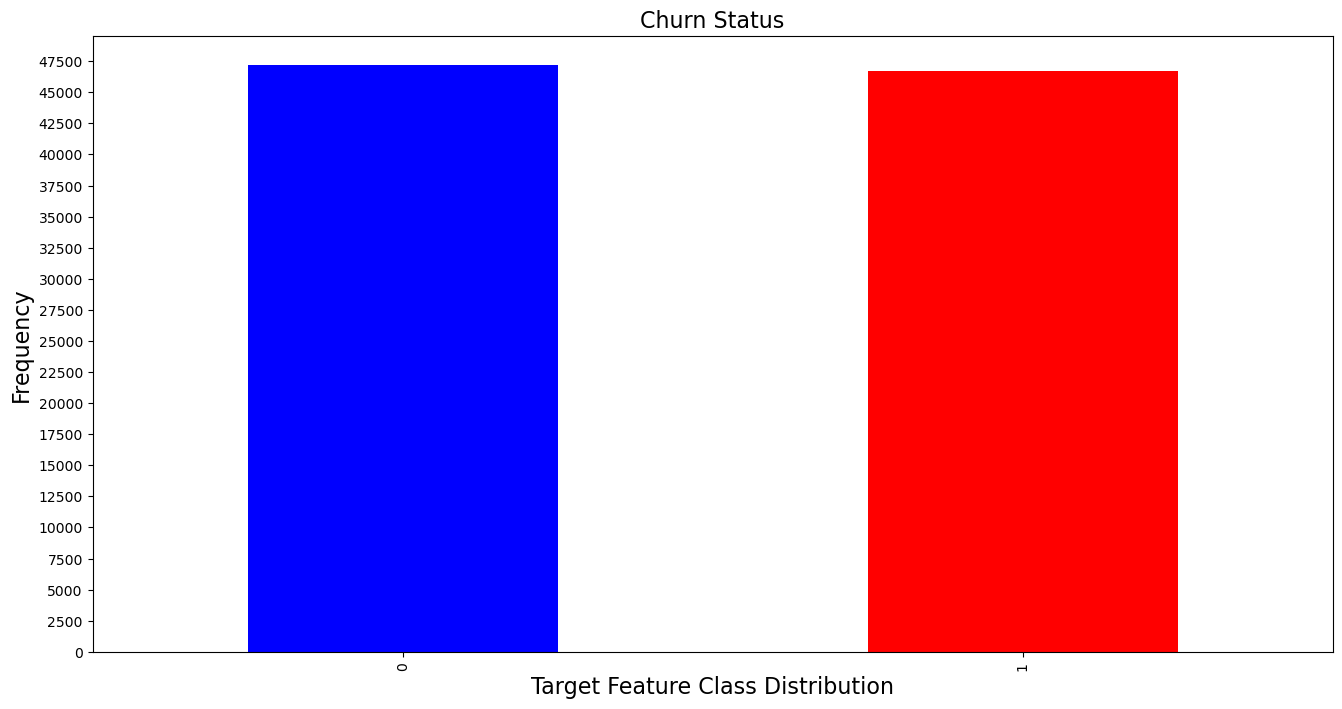

In [80]:
# Plotting the ratio between classes
from matplotlib.pyplot import figure

fig, ax = plt.subplots(figsize=(16, 8))
df['churn'].value_counts().plot.bar(color= ['blue','red'])
ax.set_ylabel('Frequency',fontsize=16)
ax.set_xlabel('Target Feature Class Distribution',fontsize=16)
ax.set_title('Churn Status',fontsize=16)
ax.locator_params('y', nbins=20)
plt.show()

#### As we can observe from the above graph, the target attribute is skewed to those who did not churn by diffirence, which will slightly weaken the model performance in predicting customers who churned, the problem here is that our focus is the customers that are churning because they're the problem that needs to be solved, therefor we need to model the imbalanced data using techniques such as downsampling, reqeighting and resampling to see which one performs better with LGBM model. 

#### we will split the data first before applying the techniques for modeling imbalanced data

In [81]:
# Identifying the feature columns
feature_cols = df.drop('churn',axis = 1).columns.tolist()
feature_cols

['rev_Mean',
 'contract',
 'totmrc_Mean',
 'da_Mean',
 'ovrmou_Mean',
 'ovrrev_Mean',
 'vceovr_Mean',
 'datovr_Mean',
 'roam_Mean',
 'tenure',
 'change_rev',
 'drop_vce_Mean',
 'drop_dat_Mean',
 'blck_vce_Mean',
 'blck_dat_Mean',
 'unan_vce_Mean',
 'unan_dat_Mean',
 'plcd_vce_Mean',
 'plcd_dat_Mean',
 'recv_vce_Mean',
 'recv_sms_Mean',
 'comp_vce_Mean',
 'comp_dat_Mean',
 'custcare_Mean',
 'ccrndmou_Mean',
 'cc_mou_Mean',
 'inonemin_Mean',
 'threeway_Mean',
 'mou_cvce_Mean',
 'mou_cdat_Mean',
 'mou_rvce_Mean',
 'owylis_vce_Mean',
 'mouowylisv_Mean',
 'iwylis_vce_Mean',
 'mouiwylisv_Mean',
 'peak_vce_Mean',
 'peak_dat_Mean',
 'mou_peav_Mean',
 'mou_pead_Mean',
 'opk_vce_Mean',
 'opk_dat_Mean',
 'mou_opkv_Mean',
 'mou_opkd_Mean',
 'drop_blk_Mean',
 'attempt_Mean',
 'complete_Mean',
 'callfwdv_Mean',
 'callwait_Mean',
 'months',
 'uniqsubs',
 'actvsubs',
 'crclscod',
 'asl_flag',
 'totcalls',
 'totmou',
 'totrev',
 'adjrev',
 'adjmou',
 'adjqty',
 'avgrev',
 'avgmou',
 'avgqty',
 'avg3mou

In [82]:
# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.25, # 25% to test the model peforamnce
                                          random_state=rs)

# We use 'next' to get the arrays from the generator object.
train_idx, test_idx = next(strat_shuf_split.split(df[feature_cols], df['churn']))

In [83]:
# Create the train and test sets
X_train = df.loc[train_idx, feature_cols] # loc[index,column]
y_train = df.loc[train_idx, 'churn']

X_test  = df.loc[test_idx, feature_cols]
y_test  = df.loc[test_idx, 'churn']

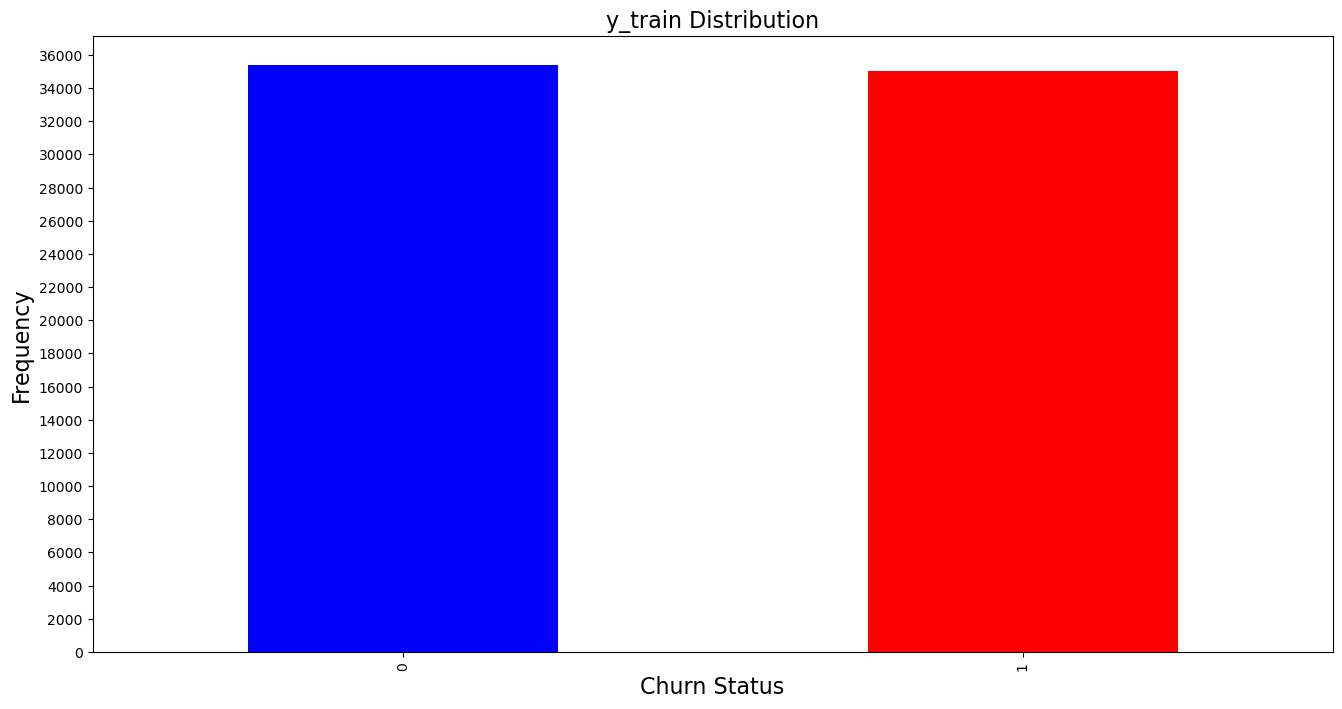

In [84]:
# Plotting y_train distribution
fig, ax = plt.subplots(figsize=(16, 8))
y_train.value_counts().plot.bar(color= ['blue','red'])
ax.set_xlabel('Churn Status',fontsize=16)
ax.set_ylabel('Frequency',fontsize=16)
ax.set_title('y_train Distribution',fontsize=16)
ax.locator_params('y', nbins=20)
plt.show()

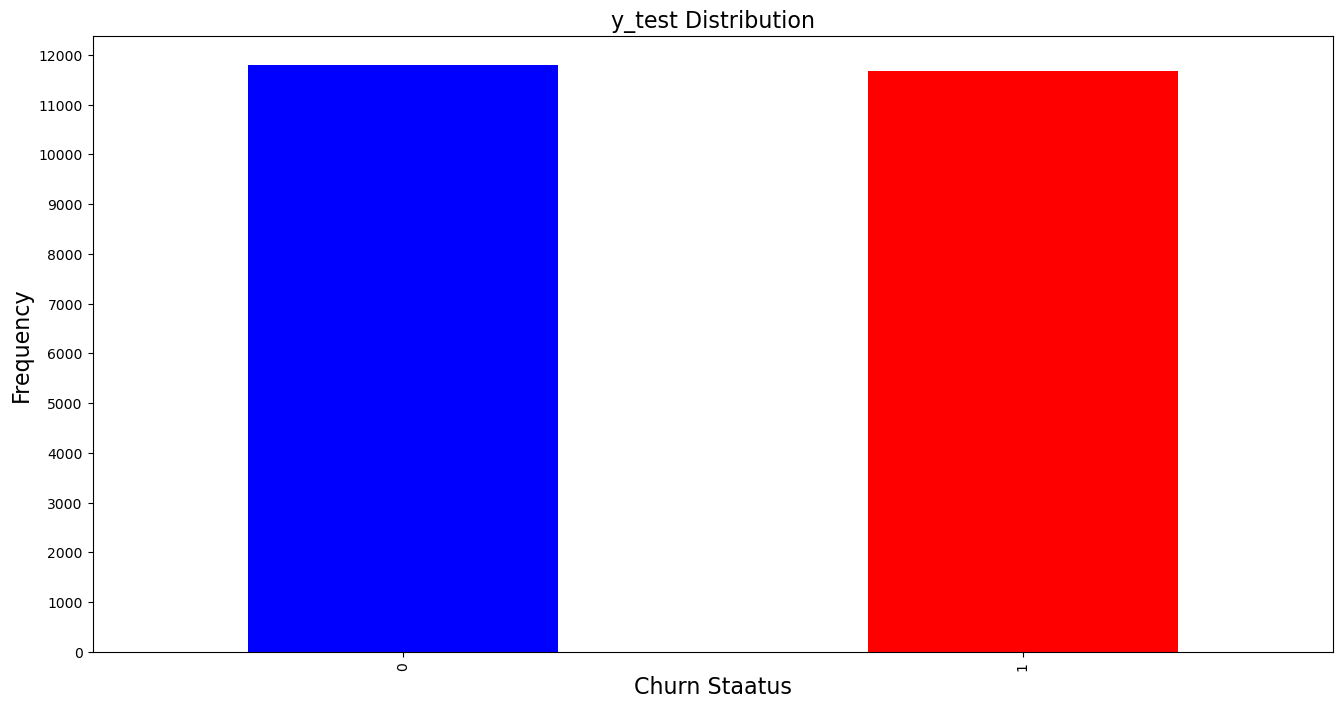

In [85]:
# Plotting y_test distribution
fig, ax = plt.subplots(figsize=(16, 8))
y_test.value_counts().plot.bar(color= ['blue','red'])
ax.set_xlabel('Churn Staatus',fontsize=16)
ax.set_ylabel('Frequency',fontsize=16)
ax.set_title('y_test Distribution',fontsize=16)
ax.locator_params('y', nbins=20)
plt.show()

#### We will use Logistic Regression to see which modeling technique performs better.

### a. Class Reweighting Teachnique

We will add the label encoded variables to teh remaining variables because they're represented with numbers so that's why the need to be scaled as well

In [86]:
mm = MinMaxScaler()# initiating a class for minmaxscaler
remaining = remaining + labelencoder_columns # adding the lists
# creating a copy of the dataset to scale it
X_train_s = X_train
X_test_s = X_test
X_train_s[remaining] = mm.fit_transform(X_train[remaining])
X_test_s[remaining] = mm.transform(X_test[remaining])




In [37]:
print('number of values in each class')
print(y_train.value_counts())
print('Proportion of each class')
print(y_train.value_counts()/len(y_train.index))

number of values in each class
0    35382
1    35037
Name: churn, dtype: int64
Proportion of each class
0    0.50245
1    0.49755
Name: churn, dtype: float64


In [38]:
class_weight = {}
# we will distribute the weight of each class according to it's proportion of the total number of values.
class_weight[0] = 0.49755
class_weight[1] = 0.50245
# notice the the proportion of the bigger class was given as the weight for the smaller class and vice versa

In [39]:
# Define a logistic regression with weight
model = LogisticRegression(solver='saga', random_state=rs, class_weight=class_weight)
model.fit(X_train_s, y_train)
preds =  model.predict(X_test_s)

In [40]:
# Results

reweighted = evaluate_metrics(y_test,preds)
reweighted

{'accuracy': 0.5868620601516572,
 'precision': array([0.59284513, 0.58131516]),
 'Weighted precision': 0.5871086325762442,
 'recall': array([0.5676134 , 0.60630191]),
 'Weighted recall': 0.5868620601516572,
 'f1score': array([0.57995495, 0.59354568]),
 'Weighted f1score': 0.5867167388268983}

In [41]:
# Storing evaluation metrics (average values)
reweighted_results = list()
keys = ['accuracy','Weighted precision','Weighted recall','Weighted f1score']
for key in keys:
       reweighted_results.append(reweighted.get(key))
reweighted_results    

[0.5868620601516572,
 0.5871086325762442,
 0.5868620601516572,
 0.5867167388268983]

In [42]:
# storing evaluation metrics (per class)
reweighted_rpf = []
elements = ['precision','recall','f1score']
for element in elements:
       reweighted_rpf.append(reweighted.get(element))
reweighted_rpf     

[array([0.59284513, 0.58131516]),
 array([0.5676134 , 0.60630191]),
 array([0.57995495, 0.59354568])]

### b. Undersampling Technique

In [87]:
under_sampler = RandomUnderSampler(random_state=rs) #initiating undersampling object
X_under, y_under = under_sampler.fit_resample(X_train_s, y_train)

In [88]:
print('y_train after undersampling')
y_under.value_counts() 

y_train after undersampling


0    35037
1    35037
Name: churn, dtype: int64

In [89]:
model = LogisticRegression(solver='saga', random_state=rs)
model.fit(X_under, y_under)
preds = model.predict(X_test_s)

In [90]:
undersampling = evaluate_metrics(y_test,preds)
undersampling

{'accuracy': 0.5878844679219563,
 'precision': array([0.5935928 , 0.58255785]),
 'Weighted precision': 0.5881025907413797,
 'recall': array([0.57024163, 0.60570254]),
 'Weighted recall': 0.5878844679219563,
 'f1score': array([0.58168295, 0.59390479]),
 'Weighted f1score': 0.5877636761184344}

In [91]:
# Storing evaluation metrics (average values)
undersampling_results = list()
for key in keys:
       undersampling_results.append(undersampling.get(key))
undersampling_results

NameError: name 'keys' is not defined

In [ ]:
# storing evaluation metrics (per class)
undersampling_rpf = []
for element in elements:
       undersampling_rpf.append(undersampling.get(element))
undersampling_rpf    

### c. Resampling Technique

In [49]:
smote_sampler = SMOTE(random_state = rs) #Initiating SMOTE sampler
X_smo, y_smo = smote_sampler.fit_resample(X_train_s, y_train)

In [50]:
y_smo.value_counts()

0    35382
1    35382
Name: churn, dtype: int64

In [51]:
model = LogisticRegression(solver='saga', random_state=rs)

In [52]:
model.fit(X_smo, y_smo)
preds = model.predict(X_test_s)

In [53]:
resampling = evaluate_metrics(y_test, preds)
resampling

{'accuracy': 0.5874158643605691,
 'precision': array([0.5932473 , 0.58199013]),
 'Weighted precision': 0.587646532335464,
 'recall': array([0.56905468, 0.60595941]),
 'Weighted recall': 0.5874158643605691,
 'f1score': array([0.58089922, 0.59373296]),
 'Weighted f1score': 0.5872843778259789}

In [54]:
# Storing evaluation metrics (average values)
resampling_results = list()
for key in keys:
       resampling_results.append(resampling.get(key))
resampling_results

[0.5874158643605691, 0.587646532335464, 0.5874158643605691, 0.5872843778259789]

In [55]:
# storing evaluation metrics (per class)
resampling_rpf = []
for element in elements:
       resampling_rpf.append(resampling.get(element))
resampling_rpf   

[array([0.5932473 , 0.58199013]),
 array([0.56905468, 0.60595941]),
 array([0.58089922, 0.59373296])]

### d. None modeled data

In [56]:
model = LogisticRegression(solver='saga', random_state=rs)
model.fit(X_train_s, y_train)
preds = model.predict(X_test_s)
no_model = evaluate_metrics(y_test, preds)
no_model

{'accuracy': 0.5869046604754196,
 'precision': array([0.59093273, 0.58301223]),
 'Weighted precision': 0.5869920512114533,
 'recall': array([0.57795676, 0.59594143]),
 'Weighted recall': 0.5869046604754196,
 'f1score': array([0.58437272, 0.58940594]),
 'Weighted f1score': 0.5868768935359434}

In [57]:
# Storing evaluation metrics (average values)
no_model_results = list()
for key in keys:
       no_model_results.append(no_model.get(key))
no_model_results

[0.5869046604754196,
 0.5869920512114533,
 0.5869046604754196,
 0.5868768935359434]

In [58]:
# storing evaluation metrics (per class)
no_model_rpf = []
for element in elements:
       no_model_rpf.append(no_model.get(element))
no_model_rpf   

[array([0.59093273, 0.58301223]),
 array([0.57795676, 0.59594143]),
 array([0.58437272, 0.58940594])]

In [59]:
final_results= {
    'Metric': ['Accuracy',' Weighted Recall','Weighted Precision','Weighted F1score'],
    'Reweighted' :reweighted_results,
    'Undersampled':undersampling_results,
    'Resampled':resampling_results,
    'no_model':no_model_results}
final_results = pd.DataFrame(final_results).set_index('Metric')
display(final_results)

,Reweighted,Undersampled,Resampled,no_model
Metric,,,,
Accuracy,0.586862,0.587884,0.587416,0.586905
Weighted Recall,0.587109,0.588103,0.587647,0.586992
Weighted Precision,0.586862,0.587884,0.587416,0.586905
Weighted F1score,0.586717,0.587764,0.587284,0.586877


Here is the best imbalanced data model for each performance metrics:
* <b>Accuracy</b>: Reweighted - 0.750710
* <b>Weighted Recall</b>: Reweighted - 0.0.801919
* <b>Weighted Precision</b>: Reweighted - 0.750710
* <b>Weighted F1score</b>: Resampled - 0.761361

Identifying customers that are going to churn is more important than identifying customers that are going to stay with the company, since missing customers that are going to churn will damage the company, because losing customers simply means less profits. Therefore, we should pay attention to score high recall (True Positive Rate or TPR) even if that means lowers precision (), because high recall means reducing the number of customers that we don’t predict to churn while they’re actually going to churn, and high precision means reducing the number of customers that we don’t predict to stay at the company while they’re actually going to stay, the problem with scoring high precision is that it doesn’t guarantee that we’re going score high prediction for those who are going to churn, it just means that out of the people we predicted to churn, most of them are actually going to churn, but this is not enough, because what if there are people we didn’t predict that they’re going to churn in the first place and they’re actually going to churn, that’s why recall suited for our problem.  

As we can see in the above table, the weighted model scored the highest value for recall, and it scored decent values in F1-score and precision, this is why we will model the data using weighting. Moreover, we can see that the data without in kind of trnasformation scored high result in the weighted recall, this is because the model was good at predicting 0s, which they refer to the people that didn't churn and they're the majority. However, the class in which we are intrerested in which is 1s, it represents the peole that churns and they're the minority, this is why without any model trnasformation, it scores very low results in recall since that model wasn't trained well on this class compared to the 0s class as we can see in the table bellow.

In [60]:
final_results_per_class = {
    'classes': [0,1],
    'Rewieghted Precision' :reweighted_rpf[0],
    'Rewieghted recall' :reweighted_rpf[1],
    'Rewieghted F1score' :reweighted_rpf[2],
    'Undersampled precision':undersampling_rpf[0],
    'Undersampled recall':undersampling_rpf[1],
    'Undersampled F1 score':undersampling_rpf[2],
    'Resampled precision':resampling_rpf[0],
    'Resampled recall':resampling_rpf[1],
    'Resampled F1 score':resampling_rpf[2],
    'no_model precision':no_model_rpf[0],
    'no_model recall':no_model_rpf[1],
    'no_model F1 score':no_model_rpf[2]}
final_results_per_class = pd.DataFrame(final_results_per_class).set_index('classes')
final_results_per_class.T

classes,0,1
Rewieghted Precision,0.592845,0.581315
Rewieghted recall,0.567613,0.606302
Rewieghted F1score,0.579955,0.593546
Undersampled precision,0.593593,0.582558
Undersampled recall,0.570242,0.605703
Undersampled F1 score,0.581683,0.593905
Resampled precision,0.593247,0.581990
Resampled recall,0.569055,0.605959
Resampled F1 score,0.580899,0.593733
no_model precision,0.590933,0.583012


<b>Based on the performance for each technique per class and for the weighted performance, we can conclude that reweighting technique the best one to choose.</b>

## Machine learning

We will start by training multiple classification machine learning models and finally we will train LGBM model and compare it's performance to the rest of the models

### a. Logistic Regression

In [61]:
# # using stratifiedkfold to guarantee even distribution in classes between training and testing sets
# skf = StratifiedKFold(shuffle=True, random_state=rs , n_splits= 4 ) # 4 splits only to reduce time. 

# # Identifying the param_grid to loop through it using GridSearchCV
# param_grid = {'C':[0.01,0.1,0.5,1,10],
#               'penalty':['l1', 'l2']}
# model = LogisticRegression(random_state = rs, solver = 'saga')

# search_lr = GridSearchCV(estimator=model,
#                       param_grid=param_grid,
#                       scoring='accuracy',
#                       cv=skf,
#                       n_jobs= -1) 
# search_lr.fit(X_under, y_under)

In [63]:
search_lr.best_score_

In [ ]:
search_lr.best_params_

In [92]:
lr_model = LogisticRegression(random_state = rs, C = 10,   penalty = 'l1', solver = 'saga', )

In [93]:
%%time
lr_model.fit(X_under, y_under)

Wall time: 13.9 s


LogisticRegression(C=10, penalty='l1', random_state=123, solver='saga')

In [94]:
preds = lr_model.predict(X_test)

In [95]:
lr = evaluate_metrics(y_test, preds)
lr # results dict

{'accuracy': 0.589077276987305,
 'precision': array([0.59489535, 0.58365567]),
 'Weighted precision': 0.5893032771896773,
 'recall': array([0.57108944, 0.60724377]),
 'Weighted recall': 0.589077276987305,
 'f1score': array([0.58274937, 0.59521611]),
 'Weighted f1score': 0.588951940403823}

              precision    recall  f1-score   support

           0       0.59      0.57      0.58     11795
           1       0.58      0.61      0.60     11679

    accuracy                           0.59     23474
   macro avg       0.59      0.59      0.59     23474
weighted avg       0.59      0.59      0.59     23474



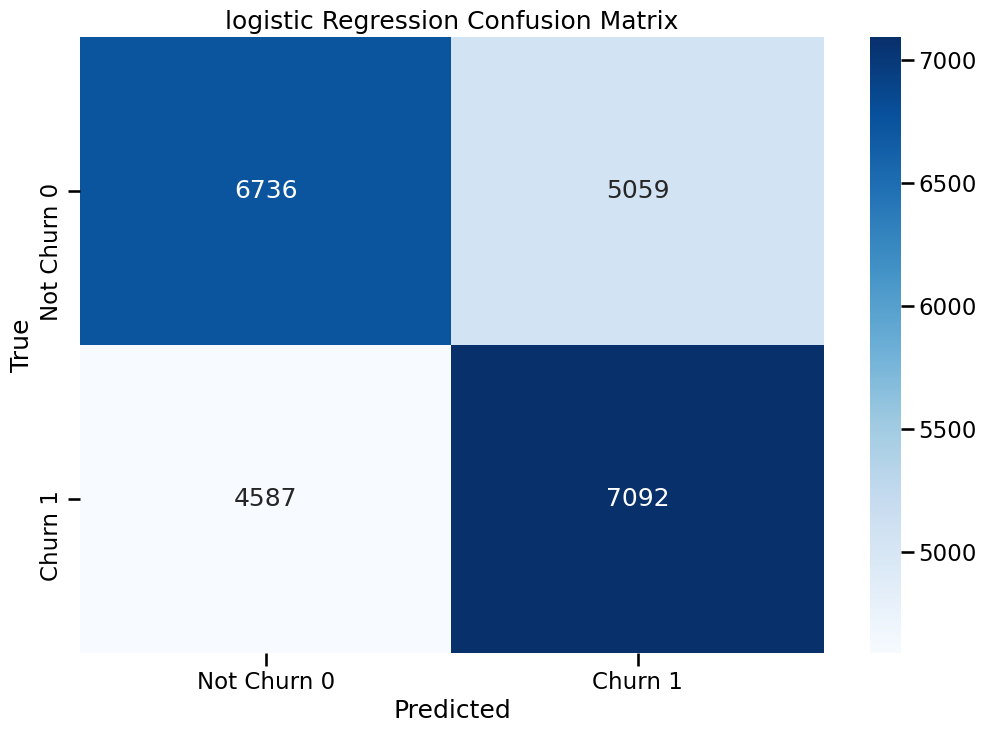

In [96]:
# Results Breakdown
print(classification_report(y_test, preds))

sns.set_context('talk')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize = (12,8)) 
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churn 0', 'Churn 1'], 
                 yticklabels=['Not Churn 0', 'Churn 1'])
ax.set(title="logistic Regression Confusion Matrix");
ax.set_xlabel('Predicted');
ax.set_ylabel('True');

In [98]:
#Storing evaluation metrics (average values)
lr_results = list()
for key in keys:
       lr_results.append(lr.get(key))
lr_results 

In [ ]:
# storing evaluation metrics (per class)
lr_rpf = []
for element in elements:
       lr_rpf.append(lr.get(element))
lr_rpf   

In [ ]:
# Saving the ML model in case we need it int he future so we don't have to train it again.
pickle.dump(search_lr, open('search_lr.p','wb')) # wb: write - bytes
pickle.dump(lr_model, open('lr_model.p','wb')) # wb: write - bytes

### Feature Importance

<b>Feature Weight</b>
using logisitc regression we can find the weight of each feature on the model, which basically represent each feature importance.

In [99]:
# this function will take the coeficients of the LR model and take the ones with highest value and lowest value so that we visualize them
from collections import OrderedDict
def highest_and_lowest_values(d):
    sorted_d = dict(OrderedDict(sorted(d.items(), key=lambda item: item[1], reverse=True)))
    highest_3 = dict(list(sorted_d.items())[:10])
    lowest_3 = dict(list(sorted_d.items())[-10:])
    return {**highest_3, **lowest_3}

In [100]:
# Get the coefficents for Class 1, Less Often
coef_dict = get_feature_coefs(lr_model, 0, feature_cols)
top_dict = highest_and_lowest_values(coef_dict)
top_dict

{'avgmou': 5.831152241814756,
 'change_rev': 4.8771118416899855,
 'rev_Mean': 4.6332453101381255,
 'roam_Mean': 3.721904311024457,
 'totmou': 3.4382567942504485,
 'avg6qty': 3.371929575131473,
 'adjmou': 2.6282963139591553,
 'ovrrev_Mean': 2.147032331610352,
 'mou_pead_Mean': 2.117040007292697,
 'uniqsubs': 2.0250501935175214,
 'adjqty': -1.9158796543684304,
 'opk_vce_Mean': -2.2363625755254986,
 'blck_dat_Mean': -2.2906780540282887,
 'threeway_Mean': -2.5313080183520777,
 'avg3rev': -2.931929959241557,
 'adjrev': -3.265069805180823,
 'avg6mou': -3.2953517669300214,
 'peak_vce_Mean': -3.617828465957049,
 'tenure': -3.9778571954755892,
 'contract': -4.28917629672046}

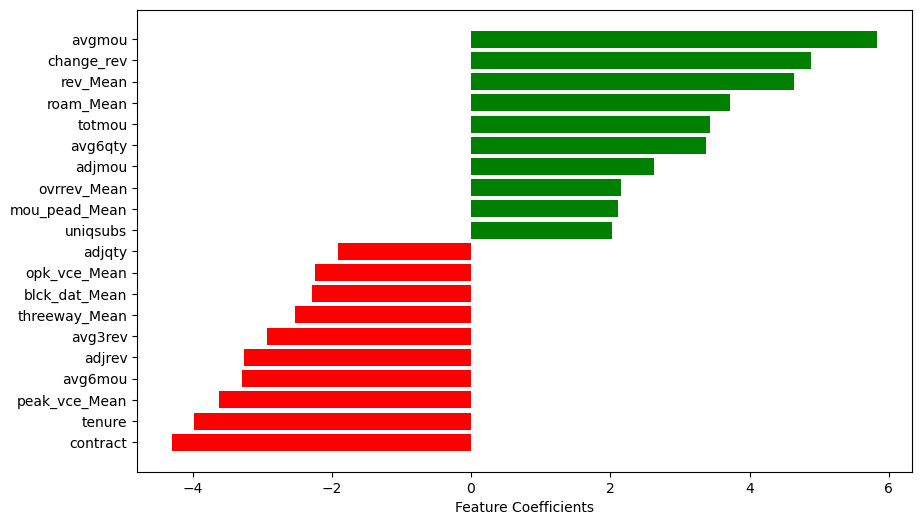

In [101]:
visualize_coefs(top_dict)

### b. Support Vector Machine 

due the high valume of data, and low computational power of the used machine, we will not implement SVM, but we will leave the codes incase someone wants to use it

In [73]:
# # Identifying the param_grid to loop through it using GridSearchCV
# params_grid = {
#     'C': [0.1,1, 10, 100],
#     'kernel': ['poly', 'rbf', 'sigmoid']
# }

# model = SVC(class_weight=class_weight)

# # Define a GridSearchCV to search the best parameters
# SVC_search = GridSearchCV(estimator = model, 
#                            param_grid = params_grid, 
#                            scoring='f1',
#                            cv = skf, verbose = 1)
# # Search the best parameters with training data
# SVC_search.fit(X_under, y_under.values.ravel())
# best_params = SVC_search.best_params_
# best_params

In [71]:
SVM_model = SVC(C=1, kernel='rbf')
SVM_model.fit(X_under, y_under.values.ravel())
preds = SVM_model.predict(X_test_s)

In [76]:
# svm_result = evaluate_metrics(y_test, preds)
# svm_result

In [77]:
# # Results Breakdown
# print(classification_report(y_test, preds))

# sns.set_context('talk')
# cm = confusion_matrix(y_test, preds)
# plt.figure(figsize = (12,8)) 
# ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=['Not Churn 0', 'Churn 1'], 
#                  yticklabels=['Not Churn 0', 'Churn 1'])
# ax.set(title="logistic Regression Confusion Matrix");
# ax.set_xlabel('Predicted');
# ax.set_ylabel('True');

In [78]:
# SVM_results = list()
# for key in keys:
#        SVM_results.append(svm_result.get(key))
# SVM_results 

In [80]:
# SVM_rpf = []
# for element in elements:
#        SVM_rpf.append(svm_result.get(element))
# SVM_rpf  

In [81]:
# pickle.dump(SVM_model, open('SVM_model.p','wb')) # wb: write - bytes

### c. Random Forest

In [ ]:
# we can't use grid search with random forest due to high time complexity

# # using GridSearchCV to identify the best performing parameters
# param_grid = {'n_estimators': [2*n+1 for n in range(20)],
#               'criterion':['gini', 'entropy'],
#              'max_depth' : [2*n+1 for n in range(10) ],
#              'max_features':["auto", "sqrt", "log2"]}
# num_combinations = 1
# for n in param_grid.values(): num_combinations *=len(n)
# print("number of possible combinations for the parameters")
# print(num_combinations)



In [ ]:
# RF_model = RandomForestClassifier(random_state = rs, bootstrap = True, class_weight = class_weight)
# search_rf = GridSearchCV(estimator=RF_model,
#                       param_grid=param_grid,
#                       scoring='f1',
#                       cv=skf,
#                       n_jobs = -1) # creating GridSearchCV object
# search_rf.fit(X_train_s, y_train)
# search_rf.best_score_

In [ ]:
# search_rf.best_params_

building a random forest model using the best parameters

In [281]:
# choosing the best parameters to build the RF model.
RF_model = RandomForestClassifier(random_state = rs, bootstrap = True, 
                                 n_estimators =29, 
                                 criterion = 'gini',
                                 max_depth = 9 ,
                                 max_features = 'log2')

In [282]:
%%time
RF_model.fit(X_under, y_under)
preds = RF_model.predict(X_test_s)
RF_result = evaluate_metrics(y_test,preds)
RF_result

Wall time: 4.33 s


{'accuracy': 0.6044985941893158,
 'precision': array([0.62449182, 0.58943909]),
 'Weighted precision': 0.6070520646007987,
 'recall': array([0.53395507, 0.67574279]),
 'Weighted recall': 0.6044985941893158,
 'f1score': array([0.57568556, 0.62964736]),
 'Weighted f1score': 0.6025331285522392}

              precision    recall  f1-score   support

           0       0.62      0.53      0.58     11795
           1       0.59      0.68      0.63     11679

    accuracy                           0.60     23474
   macro avg       0.61      0.60      0.60     23474
weighted avg       0.61      0.60      0.60     23474



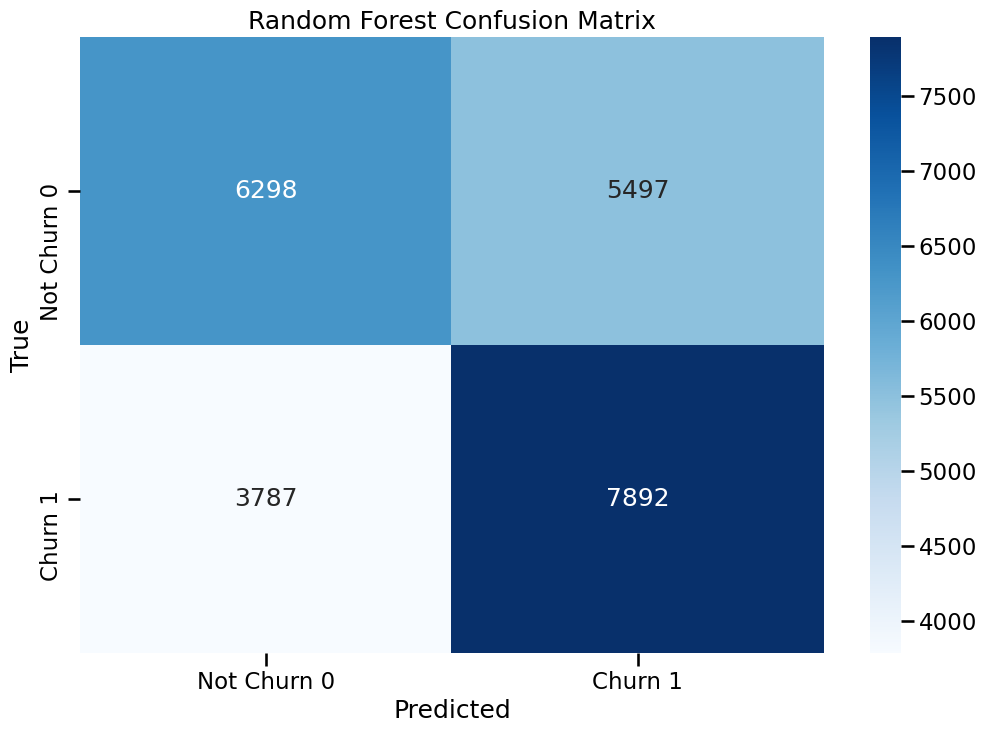

In [283]:
# Results Breakdown
print(classification_report(y_test, preds))

sns.set_context('talk')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize = (12,8)) 
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churn 0', 'Churn 1'], 
                 yticklabels=['Not Churn 0', 'Churn 1'])
ax.set(title="Random Forest Confusion Matrix");
ax.set_xlabel('Predicted');
ax.set_ylabel('True');

In [284]:
RF_results = list()
for key in keys:
       RF_results.append(RF_result.get(key))
RF_results 

[0.6044985941893158,
 0.6070520646007987,
 0.6044985941893158,
 0.6025331285522392]

In [285]:
RF_rpf = []
for element in elements:
       RF_rpf.append(RF_result.get(element))
RF_rpf  

[array([0.62449182, 0.58943909]),
 array([0.53395507, 0.67574279]),
 array([0.57568556, 0.62964736])]

In [286]:
pickle.dump(RF_model, open('RF_model.p','wb')) # write it as bytes

### d. XGboost

In [54]:
xgb.XGBClassifier().get_params() # printing XGboost parameters

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [287]:
# Splitting part of the training set to become the validation set for training XGboost
# Get the split indexes
strat_shuf_split_valid = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.15, # 15% to test the model peforamnce
                                          random_state=rs)

# We use 'next' to get the arrays from the generator object.
XGtrain_idx, XGvalid_idx = next(strat_shuf_split_valid.split(X_under, y_under))

# Create the train and validations sets
X_XGtrain = X_under.loc[XGtrain_idx, X_under.columns] # loc[index,column]
y_XGtrain = y_under.loc[XGtrain_idx]

X_XGvalid  = X_under.loc[XGvalid_idx, X_under.columns]
y_XGvalid  = y_under.loc[XGvalid_idx]

In [91]:
# # weight parameter in XGBoost is per instance not per class.
# # Therefore, we need to assign the weight of each class to its instances
# from sklearn.utils import class_weight
# classes_weights = list(class_weight.compute_class_weight(class_weight = 'balanced',
#                                              classes = np.unique(y_XGtrain),
#                                              y = y_XGtrain))

# weights = np.ones(y_XGtrain.shape[0], dtype = 'float') # returns an array with predefined shape and values of 1
# for i, val in enumerate(y_XGtrain):
#     weights[i] = classes_weights[val]

# weights


performing GridSearchSV to find the best parameters for XGboost

In [92]:
# learning_rate_list = [0.02, 0.05, 0.1]
# max_depth_list = [2, 3, 5]
# n_estimators_list = [1000, 2000, 3000]

# params_dict = {"learning_rate": learning_rate_list,
#                "max_depth": max_depth_list,
#                "n_estimators": n_estimators_list}

# num_combinations = 1
# for v in params_dict.values(): num_combinations *= len(v) 

# print(num_combinations)
# params_dict

In [93]:
# def my_roc_auc_score(model, X, y): return roc_auc_score(y, model.predict_proba(X)[:,1])

# model_xgboost_hp = GridSearchCV(estimator=xgb.XGBClassifier(subsample=0.5,
#                                                                 colsample_bytree=0.25,
#                                                                 eval_metric='auc',
#                                                                 use_label_encoder=False),
#                                 param_grid=params_dict,
#                                 cv=2,
#                                 scoring=my_roc_auc_score,
#                                 return_train_score=True,
#                                 verbose=4)

# model_xgboost_hp.fit(X_XGtrain,y_XGtrain)

In [94]:
# model_xgboost_hp.best_params_

In [288]:
%%time
# Initiating XGboost object
model_xgboost = xgb.XGBClassifier(learning_rate=0.02,
                                      max_depth=2,
                                      n_estimators=1000,
                                      subsample=0.5,
                                      colsample_bytree=0.5,
                                      eval_metric='auc',
                                      verbosity=1)


eval_set = [(X_XGvalid, y_XGvalid)]

model_xgboost.fit(X_XGtrain,
                  y_XGtrain,
                  early_stopping_rounds=10,
                  eval_set=eval_set,
                  verbose=True)

[0]	validation_0-auc:0.55306
[1]	validation_0-auc:0.60857
[2]	validation_0-auc:0.61552
[3]	validation_0-auc:0.61737
[4]	validation_0-auc:0.61943
[5]	validation_0-auc:0.62099
[6]	validation_0-auc:0.62102
[7]	validation_0-auc:0.62249
[8]	validation_0-auc:0.62294
[9]	validation_0-auc:0.62263
[10]	validation_0-auc:0.62315
[11]	validation_0-auc:0.62772
[12]	validation_0-auc:0.62745
[13]	validation_0-auc:0.62670
[14]	validation_0-auc:0.62749
[15]	validation_0-auc:0.62698
[16]	validation_0-auc:0.62696
[17]	validation_0-auc:0.62714
[18]	validation_0-auc:0.62672
[19]	validation_0-auc:0.62742
[20]	validation_0-auc:0.62762
[21]	validation_0-auc:0.62801
[22]	validation_0-auc:0.62791
[23]	validation_0-auc:0.62970
[24]	validation_0-auc:0.62969
[25]	validation_0-auc:0.62960
[26]	validation_0-auc:0.62952
[27]	validation_0-auc:0.63027
[28]	validation_0-auc:0.63017
[29]	validation_0-auc:0.63000
[30]	validation_0-auc:0.63014
[31]	validation_0-auc:0.63001
[32]	validation_0-auc:0.62977
[33]	validation_0-au

[268]	validation_0-auc:0.65655
[269]	validation_0-auc:0.65654
[270]	validation_0-auc:0.65654
[271]	validation_0-auc:0.65660
[272]	validation_0-auc:0.65663
[273]	validation_0-auc:0.65672
[274]	validation_0-auc:0.65667
[275]	validation_0-auc:0.65674
[276]	validation_0-auc:0.65676
[277]	validation_0-auc:0.65675
[278]	validation_0-auc:0.65678
[279]	validation_0-auc:0.65690
[280]	validation_0-auc:0.65704
[281]	validation_0-auc:0.65711
[282]	validation_0-auc:0.65720
[283]	validation_0-auc:0.65724
[284]	validation_0-auc:0.65737
[285]	validation_0-auc:0.65744
[286]	validation_0-auc:0.65744
[287]	validation_0-auc:0.65742
[288]	validation_0-auc:0.65745
[289]	validation_0-auc:0.65762
[290]	validation_0-auc:0.65777
[291]	validation_0-auc:0.65784
[292]	validation_0-auc:0.65789
[293]	validation_0-auc:0.65797
[294]	validation_0-auc:0.65803
[295]	validation_0-auc:0.65815
[296]	validation_0-auc:0.65811
[297]	validation_0-auc:0.65819
[298]	validation_0-auc:0.65825
[299]	validation_0-auc:0.65822
[300]	va

[533]	validation_0-auc:0.66878
[534]	validation_0-auc:0.66879
[535]	validation_0-auc:0.66885
[536]	validation_0-auc:0.66889
[537]	validation_0-auc:0.66893
[538]	validation_0-auc:0.66894
[539]	validation_0-auc:0.66896
[540]	validation_0-auc:0.66905
[541]	validation_0-auc:0.66905
[542]	validation_0-auc:0.66911
[543]	validation_0-auc:0.66914
[544]	validation_0-auc:0.66925
[545]	validation_0-auc:0.66928
[546]	validation_0-auc:0.66926
[547]	validation_0-auc:0.66936
[548]	validation_0-auc:0.66937
[549]	validation_0-auc:0.66945
[550]	validation_0-auc:0.66947
[551]	validation_0-auc:0.66952
[552]	validation_0-auc:0.66949
[553]	validation_0-auc:0.66958
[554]	validation_0-auc:0.66965
[555]	validation_0-auc:0.66969
[556]	validation_0-auc:0.66970
[557]	validation_0-auc:0.66975
[558]	validation_0-auc:0.66972
[559]	validation_0-auc:0.66977
[560]	validation_0-auc:0.66982
[561]	validation_0-auc:0.66990
[562]	validation_0-auc:0.66993
[563]	validation_0-auc:0.66999
[564]	validation_0-auc:0.67001
[565]	va

[798]	validation_0-auc:0.67496
[799]	validation_0-auc:0.67497
[800]	validation_0-auc:0.67502
[801]	validation_0-auc:0.67507
[802]	validation_0-auc:0.67510
[803]	validation_0-auc:0.67514
[804]	validation_0-auc:0.67516
[805]	validation_0-auc:0.67520
[806]	validation_0-auc:0.67517
[807]	validation_0-auc:0.67518
[808]	validation_0-auc:0.67521
[809]	validation_0-auc:0.67521
[810]	validation_0-auc:0.67523
[811]	validation_0-auc:0.67525
[812]	validation_0-auc:0.67528
[813]	validation_0-auc:0.67530
[814]	validation_0-auc:0.67530
[815]	validation_0-auc:0.67530
[816]	validation_0-auc:0.67528
[817]	validation_0-auc:0.67529
[818]	validation_0-auc:0.67530
[819]	validation_0-auc:0.67528
[820]	validation_0-auc:0.67527
[821]	validation_0-auc:0.67528
[822]	validation_0-auc:0.67525
[823]	validation_0-auc:0.67526
[824]	validation_0-auc:0.67527
[825]	validation_0-auc:0.67527
Wall time: 51.9 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=1)

In [289]:
preds = model_xgboost.predict(X_test_s)
XG_result = evaluate_metrics(y_test,preds)
XG_result

{'accuracy': 0.621623924341825,
 'precision': array([0.63363611, 0.61121272]),
 'Weighted precision': 0.6224798226639335,
 'recall': array([0.58550233, 0.65810429]),
 'Weighted recall': 0.621623924341825,
 'f1score': array([0.60861902, 0.63379236]),
 'Weighted f1score': 0.621143492418645}

              precision    recall  f1-score   support

           0       0.63      0.59      0.61     11795
           1       0.61      0.66      0.63     11679

    accuracy                           0.62     23474
   macro avg       0.62      0.62      0.62     23474
weighted avg       0.62      0.62      0.62     23474



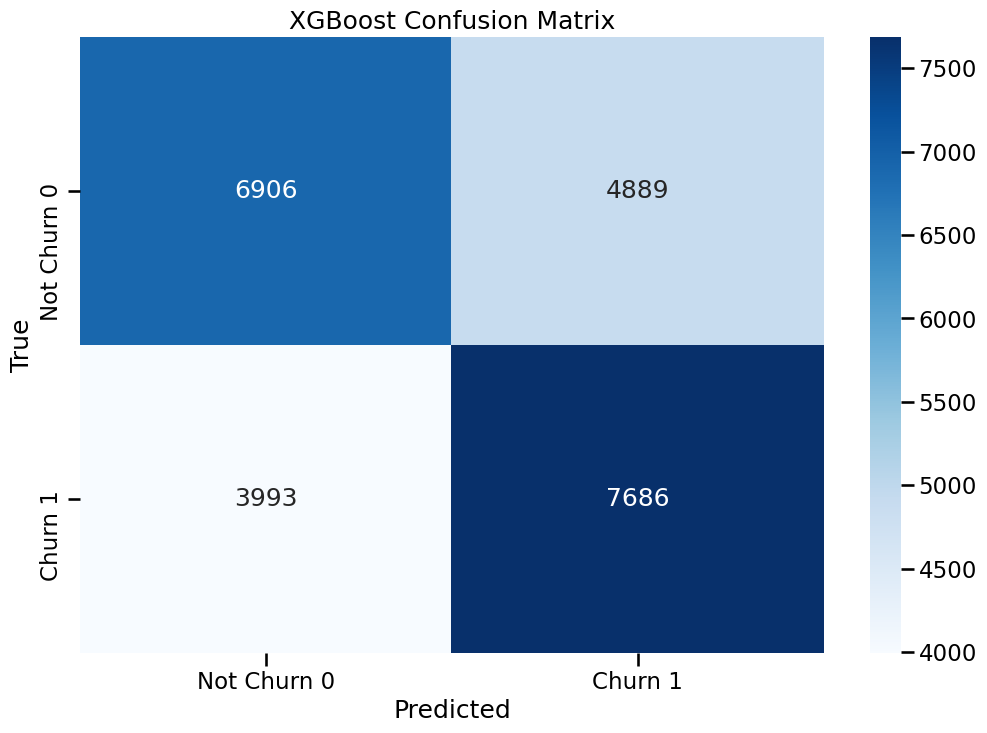

In [290]:
# Results Breakdown
print(classification_report(y_test, preds))

sns.set_context('talk')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize = (12,8)) 
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churn 0', 'Churn 1'], 
                 yticklabels=['Not Churn 0', 'Churn 1'])
ax.set(title="XGBoost Confusion Matrix");
ax.set_xlabel('Predicted');
ax.set_ylabel('True');

In [291]:
XG_results = list()
for key in keys:
       XG_results.append(XG_result.get(key))
XG_results 

[0.621623924341825, 0.6224798226639335, 0.621623924341825, 0.621143492418645]

In [292]:
XG_rpf = []
for element in elements:
       XG_rpf.append(XG_result.get(element))
XG_rpf 

[array([0.63363611, 0.61121272]),
 array([0.58550233, 0.65810429]),
 array([0.60861902, 0.63379236])]

In [293]:
pickle.dump(model_xgboost, open('model_xgboost.p','wb')) # write it as bytes

### e. Light Gradient Boosted Machine LGBM

In [294]:
LGBMClassifier().get_params() # printing LGBM parameters

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [295]:
# # defining the parameters to be tuned:
# n_estimators= [100, 200, 300, 500, 1000]
# num_leaves= [15, 20, 30]
# colsample_bytree= [0.6, 0.8, 1]
# subsample= [0.6, 0.8, 1]
# max_depth= [1, 3, 5, 7, 9, 11]
# reg_alpha= [0.6, 0.8, 1]
# reg_lambda= [ 0.6, 0.8, 1]
# min_split_gain=[0.02, 0.04]
# learning_rate = [0.1, 0.2, 0.3]

# param_grid = {
#     'n_estimators':n_estimators,
#     'num_leaves':num_leaves,
#     'colsample_bytree':colsample_bytree,
#     'subsample':subsample,
#     'max_depth':max_depth,
#     'reg_alpha':reg_alpha,
#     'reg_lambda':reg_lambda,
#     'min_split_gain':min_split_gain,
#     'learning_rate':learning_rate
    
# }

# LGBM_model = LGBMClassifier( random_state = rs, bootstrap = True, class_weight = class_weight )


# search_lgbm = GridSearchCV(estimator=LGBM_model,
#                       param_grid=param_grid,
#                       scoring='f1',
#                       cv=skf,
#                       n_jobs = -1) # creating GridSearchCV object

# search_lgbm.fit(X_train_s, y_train)
# search_lgbm.best_score_

In [296]:
# search_lgbm.best_params_

In [298]:
%%time
clf_lgbm = LGBMClassifier(
  learning_rate = 0.1,
        n_estimators=300,
        num_leaves=15,
        colsample_bytree=0.6,
        subsample= 0.6,
        max_depth=3,
        reg_alpha=0.6,
        reg_lambda= 0.8,
        min_split_gain=.02,
        boosting_type= 'goss'
    )
# using the same train and validations set we used in XGboost.
clf_lgbm.fit(X_XGtrain,
                  y_XGtrain,
        eval_set= [(X_XGvalid, y_XGvalid)], 
        eval_metric='auc', 
        verbose=0, 
        early_stopping_rounds=30
       )


Wall time: 2.17 s


LGBMClassifier(boosting_type='goss', colsample_bytree=0.6, max_depth=3,
               min_split_gain=0.02, n_estimators=300, num_leaves=15,
               reg_alpha=0.6, reg_lambda=0.8, subsample=0.6)

In [299]:
preds = clf_lgbm.predict(X_test_s)
lgbm_result = evaluate_metrics(y_test,preds)
lgbm_result


{'accuracy': 0.6262247593081708,
 'precision': array([0.63560463, 0.61775436]),
 'Weighted precision': 0.6267235997403037,
 'recall': array([0.60025435, 0.65245312]),
 'Weighted recall': 0.6262247593081708,
 'f1score': array([0.61742391, 0.6346298 ]),
 'Weighted f1score': 0.6259843430605043}

              precision    recall  f1-score   support

           0       0.64      0.60      0.62     11795
           1       0.62      0.65      0.63     11679

    accuracy                           0.63     23474
   macro avg       0.63      0.63      0.63     23474
weighted avg       0.63      0.63      0.63     23474



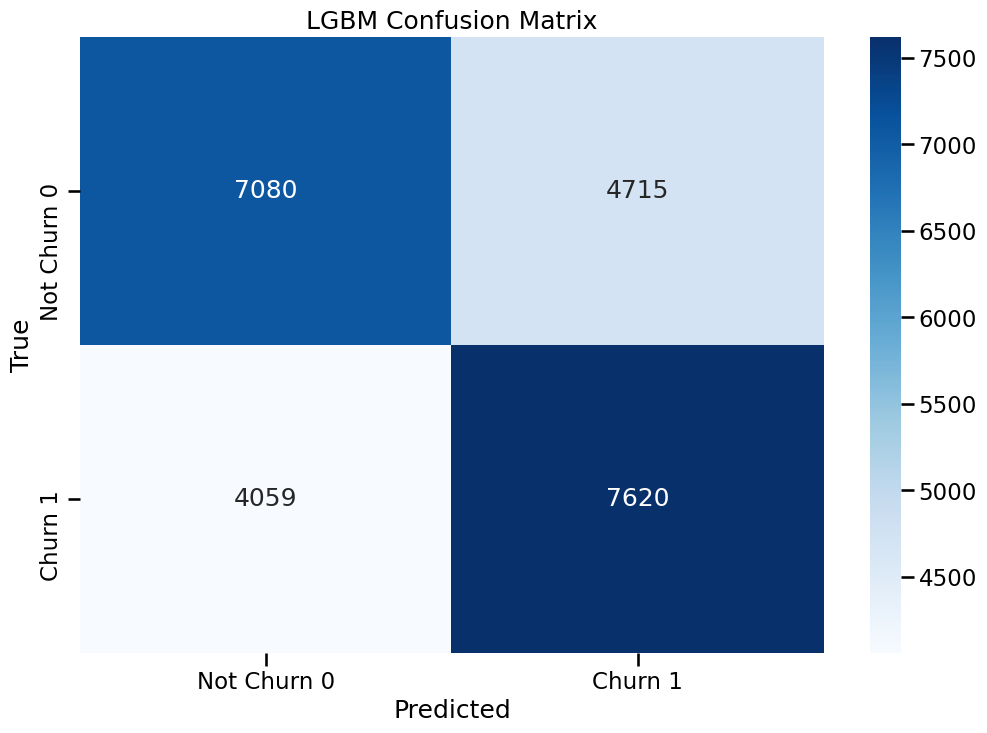

In [300]:
# Results Breakdown
print(classification_report(y_test, preds))

sns.set_context('talk')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize = (12,8)) 
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churn 0', 'Churn 1'], 
                 yticklabels=['Not Churn 0', 'Churn 1'])
ax.set(title="LGBM Confusion Matrix");
ax.set_xlabel('Predicted');
ax.set_ylabel('True');

In [301]:
LGBM_results = list()
for key in keys:
       LGBM_results.append(lgbm_result.get(key))
LGBM_results 

[0.6262247593081708,
 0.6267235997403037,
 0.6262247593081708,
 0.6259843430605043]

In [302]:
LGBM_rpf = []
for element in elements:
       LGBM_rpf.append(lgbm_result.get(element))
LGBM_rpf 

[array([0.63560463, 0.61775436]),
 array([0.60025435, 0.65245312]),
 array([0.61742391, 0.6346298 ])]

In [ ]:
pickle.dump(clf_lgbm, open('clf_lgbm.p','wb')) # write it as bytes

In [304]:
final_results= {
    'Metric': ['Accuracy',' Weighted Precision','Weighted Recall','Weighted F1score'],
    'Logistic Regression' :lr_results,
    'Random Forest'      :RF_results,
    'XGboost'            :XG_results,
    'LGBM'               :LGBM_results}
final_results = pd.DataFrame(final_results).set_index('Metric')
display(final_results)    

,Logistic Regression,Random Forest,XGboost,LGBM
Metric,,,,
Accuracy,0.589077,0.604499,0.621624,0.626225
Weighted Precision,0.589303,0.607052,0.622480,0.626724
Weighted Recall,0.589077,0.604499,0.621624,0.626225
Weighted F1score,0.588952,0.602533,0.621143,0.625984


In [306]:
final_results_per_class = {
    'classes': [0,1],
    'LR Precision' :lr_rpf[0],
    'LR Recall' :lr_rpf[1],
    'LR F1score' :lr_rpf[2],
    'RF Precision':RF_rpf[0],
    'RF Recall':RF_rpf[1],
    'RF F1 score':RF_rpf[2],
    'XG Precision':XG_rpf[0],
    'XG Recall':XG_rpf[1],
    'XG F1 score':XG_rpf[2],
    'LGBM Precision':LGBM_rpf[0],
    'LGBM Recall':LGBM_rpf[1],
    'LGBM F1 score':LGBM_rpf[2]}
final_results_per_class = pd.DataFrame(final_results_per_class).set_index('classes')
final_results_per_class.T

classes,0,1
LR Precision,0.594895,0.583656
LR Recall,0.571089,0.607244
LR F1score,0.582749,0.595216
RF Precision,0.624492,0.589439
RF Recall,0.533955,0.675743
RF F1 score,0.575686,0.629647
XG Precision,0.633636,0.611213
XG Recall,0.585502,0.658104
XG F1 score,0.608619,0.633792
LGBM Precision,0.635605,0.617754


### main outcomes:

* The data is sckewed by a percentage of approximately 70% to those who did not churn
* Random Forest Scored the highest accuracy, however, since reducing the number of churn is our main target, accuracy is not enough as a pefromance metrics
* XGboost scored the highest recall for churn class (1).however, it scored poorly on those who didn't churn which makes the prediction ineligible.
* LGBM scored decent recall average as it's weighted recall is not scewed by class 0

### Proposal for feature work:
* implementing LGBM model on a larger dataset (more than 10000 rows), since it's not suitable for small datasets and tuning it's parameters in small datasets has an unoticeable effect